### 1. Find base_lr and max_lr
Calculate the upper bound of the learning rate for your model. The way to do this is to:
1. Define an initial learning rate, the lower boundary of the range you want to test (let’s say 1e-7)
2. Define an upper boundary of the range (let’s say 0.1)
3. Define an exponential scheme to run through this step by step: <br>
```python
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( data_loader["train"])))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
```
<br>
Note: Youdon’t take the ‘raw’ loss at each step, but the smoothed loss, being: loss = α . loss + (1- α). previous_loss

In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# own Modules 
from models import LstmMseDropout
from data_loader import DataPreperator, DataSet
from trainer import Trainer
from loss_module import LossModuleMse, LossModuleMle

In [2]:
param = {
    "data" : {
        "stake_training_data" : 0.75, 
        "path" : '../../../data/phm_data_challenge/01_M01_DC_preprocessed_training.csv' ,
    },
    "preprocessing" : {
        "first_order_difference" : False,
        "droped_features": ["up time", "ongoing time", "RLU", "runnum"]
    },
    "model" : {
        "input_size" : 21,
        "n_hidden_lstm" : 200,
        "sequence_size" : 150,
        "batch_size" : 8,
        "lstm_layer" : 2,
        "n_hidden_fc": 75,
        "dropout_rate": 0.2
    },
    "training": {
        "n_epochs" : 100,
        "patience" : 10,
    },
}

In [3]:
train_loader = DataPreperator(path=param['data']['path'], 
                              ignored_features=param['preprocessing']['droped_features'],
                              stake_training_data=param['data']['stake_training_data'],
                              first_order_difference=param["preprocessing"]["first_order_difference"])
train_data, validation_data = train_loader.prepare_data()

In [4]:
dataset_train = DataSet(train_data, timesteps=param["model"]["sequence_size"])
dataset_validation = DataSet(validation_data, timesteps=param["model"]["sequence_size"])

In [5]:
data_loader_training = DataLoader(dataset_train, batch_size=param["model"]["batch_size"], 
                                  num_workers=1, shuffle=True, drop_last=True)
data_loader_validation = DataLoader(dataset_validation, batch_size=param["model"]["batch_size"], 
                                    num_workers=1, shuffle=True, drop_last=True)

In [6]:
for batch_idx, data in enumerate(data_loader_training):
    x,y = data
    print('Data of batch: {}'.format(batch_idx))
    print("Size of input data: {}".format(x.size()))
    print("Size of target data: {}".format(y.size()))
    if batch_idx >=1: break

Data of batch: 0
Size of input data: torch.Size([8, 150, 21])
Size of target data: torch.Size([8, 21])
Data of batch: 1
Size of input data: torch.Size([8, 150, 21])
Size of target data: torch.Size([8, 21])


In [7]:
torch.manual_seed(0)
model = LstmMseDropout(batch_size=param['model']['batch_size'], 
                       input_dim=param['model']['input_size'], 
                       n_hidden_lstm=param['model']['n_hidden_lstm'], 
                       n_layers=param['model']['lstm_layer'],
                       dropout_rate= param['model']['dropout_rate'],
                       n_hidden_fc=param['model']['n_hidden_fc']
                       )

In [8]:
criterion = LossModuleMse(param["model"]["input_size"], param["model"]["batch_size"])

# Training

In [9]:
# Experiment parameters
lr_find_epochs = 3
start_lr = 1e-3
end_lr = 1
smoothing = 0.005

optimizer = torch.optim.SGD(model.parameters(), lr=start_lr)  
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len(data_loader_training)))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Make lists to capture the logs
lr_find_loss = []
lr_find_lr = []

for i in range(lr_find_epochs):
    epoch_training_loss = []
    print("epoch {}".format(i))
    for batch_number, data in enumerate(data_loader_training):
        
        input_data, target_data = data
        # Training mode and zero gradients
        model.train()
        hidden = model.init_hidden()
        optimizer.zero_grad()

        # Get outputs to calc loss
        output = model(input_data, hidden)
        
        # Computate loss
        criterion = nn.MSELoss()
        loss = criterion(output, target_data)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update LR
        scheduler.step()
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        # smooth the loss
        if batch_number==0:
            lr_find_loss.append(loss.item())
        else:
            loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
            lr_find_loss.append(loss)

epoch 0


/Users/carlovoss/jupyter_notebooks/masterarbeit/venv_pm/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1
epoch 2


In [10]:
import numpy as np
import pandas as pd
data = pd.DataFrame(data={'iteration': range(len(lr_find_lr)), 'learning_rate': lr_find_lr, 'loss': lr_find_loss})
data['log_value'] = np.log(data['learning_rate'])
data.head()

,iteration,learning_rate,loss,log_value
0,0,0.00001,0.548459,-11.509597
1,1,0.00001,0.550863,-11.506269
2,2,0.00001,0.552147,-11.502940
3,3,0.00001,0.552526,-11.499612
4,4,0.00001,0.553270,-11.496283


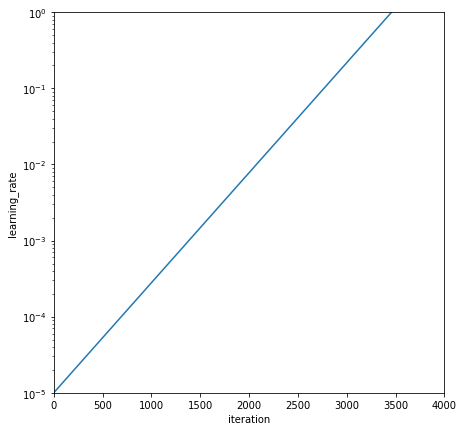

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
plt.ylim(start_lr, end_lr)
plt.xlim(0, 4000)

sns.lineplot(x=data.iteration, y=data.learning_rate, ax=ax)
plt.savefig("./lowerandupperLR.png")
plt.show()

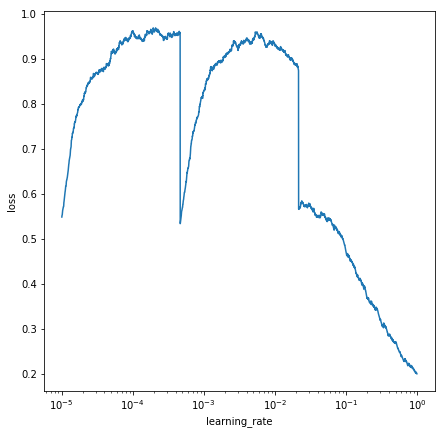

In [12]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.lineplot(x=data.learning_rate, y=data.loss, ax=ax)
plt.savefig("./select_max_LR.png")
plt.show()

__Example for possible outcome:__
![](../../../knowledge/pictures/learning_rate.png)

- A good upper bound (max_lr) is not on the lowest point, but about a factor of 10 to the left. (In this case 3e-3)
- A good lower bound (base_lr), according to the paper and other sources, is the upper bound, divided by a factor 6.